In [4]:
from fastai.vision.all import *
import os

In [49]:
files = get_image_files("subset")
len(files)
# files
os.getcwd()+"/subset"

'C:\\Users\\magnu\\OneDrive\\Dokumente\\Datathon_2022/subset'

In [48]:
import pandas as pd
N_FILES = 200000
columns = df_att.columns

df_eval = pd.read_csv("eval_data_public.csv")
df_train = pd.read_csv("train_data.csv")
df_att = pd.read_csv("list_attr_celeba.csv").set_index("image_id")
df_att = df_att.replace({-1:0})

s_eval = df_eval.set_index("id")["16_image_ids"]
df_train = df_train.set_index("id")[["16_image_ids","anomalous_image_id","attributes"]]
for col in columns:
    df_att[col] = df_att[col].apply(bool)


In [49]:
def get_labels(row):
    return ",".join(list(columns[row]))

label_list = list(df_att.apply(get_labels,axis=1))

path = "lumos_datathon/archive/img_align_celeba"
df = pd.DataFrame.from_dict({"name": list(df_att.index)[:N_FILES], "labels": label_list[:N_FILES]})
df
dls = ImageDataLoaders.from_df(df, path,label_delim=",")

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


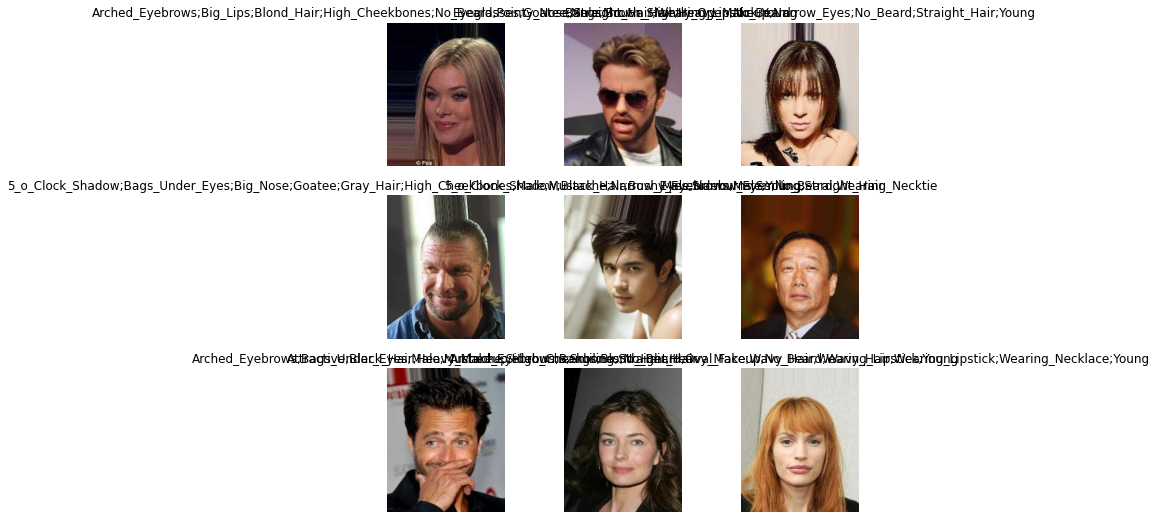

In [46]:
dls.show_batch()

In [51]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
learn = vision_learner(dls, resnet34, metrics=[partial(accuracy_multi, thresh=0.5) ,f1_macro,  f1_samples])


# learn.lr_find()
learn.fine_tune(10, 0.003)

epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.247958,0.227586,0.899260,0.603692,0.733647,18:14


epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.208824,0.194435,0.914285,0.701568,0.780753,11:07
1,0.203213,0.191846,0.915329,0.708354,0.782977,11:07
2,0.196941,0.187071,0.917780,0.698885,0.788132,11:07
3,0.186488,0.183099,0.919387,0.723944,0.796918,11:09
4,0.176159,0.183657,0.919415,0.728466,0.797089,11:10
5,0.158700,0.186696,0.919132,0.733852,0.796670,11:12
6,0.134741,0.198269,0.918292,0.734599,0.794921,11:10
7,0.110336,0.220698,0.916858,0.735677,0.793328,11:09
8,0.087440,0.246825,0.915144,0.732202,0.789688,11:12
9,0.076669,0.255148,0.914643,0.731508,0.788557,11:10


C:\Users\Magnus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


,target,predicted,probabilities,loss
0,Big_Lips;Blurry;Chubby;Eyeglasses;Goatee;Male;Mustache;Narrow_Eyes;Sideburns;Wavy_Hair,Big_Nose;Male;Mouth_Slightly_Open;Mustache,"TensorBase([4.9637e-03, 1.7964e-06, 1.3268e-04, 9.0383e-06, 4.5363e-07, 1.4844e-06,\n 8.9058e-02, 6.1444e-01, 1.1555e-02, 6.9145e-06, 1.4905e-03, 3.7688e-05,\n 4.6783e-02, 4.0760e-04, 1.7117e-05, 1.1810e-01, 1.5182e-01, 1.2332e-04,\n 7.8833e-07, 2.5446e-03, 1.0000e+00, 9.9854e-01, 8.4029e-01, 1.8615e-06,\n 7.5682e-04, 3.6924e-02, 1.6822e-06, 8.0029e-04, 1.1514e-05, 2.1498e-07,\n 9.4146e-03, 7.8826e-05, 5.0965e-04, 1.4404e-05, 1.3957e-05, 1.8729e-01,\n 6.2904e-07, 6.7420e-04, 5.0259e-07, 1.9557e-01])",1.4490338563919067
1,Attractive;Bangs;Brown_Hair;Heavy_Makeup;High_Cheekbones;Mouth_Slightly_Open;Narrow_Eyes;Oval_Face;Smiling;Wearing_Lipstick;Wearing_Necklace;Young,Bangs;Brown_Hair;No_Beard;Wavy_Hair;Young,"TensorBase([4.2872e-07, 2.7949e-04, 8.2530e-02, 3.8613e-05, 2.8308e-08, 5.5373e-01,\n 3.3559e-02, 1.0846e-04, 1.9408e-05, 1.8716e-07, 1.0004e-01, 9.9844e-01,\n 6.1573e-04, 2.2597e-06, 1.8164e-07, 1.9079e-07, 4.1287e-07, 4.6304e-08,\n 5.6846e-03, 2.6825e-02, 1.7654e-04, 7.5686e-05, 1.0078e-06, 2.9565e-01,\n 1.0000e+00, 3.0740e-02, 1.1426e-05, 2.9589e-01, 2.6801e-05, 3.2743e-05,\n 9.0678e-07, 1.5294e-03, 9.7301e-04, 5.8108e-01, 1.0674e-03, 1.6802e-06,\n 3.4237e-02, 9.0439e-04, 9.2799e-09, 9.9986e-01])",1.422561526298523
2,Big_Lips;Big_Nose;Bushy_Eyebrows;Chubby;High_Cheekbones;Male;Young,Mouth_Slightly_Open;Narrow_Eyes;No_Beard;Wearing_Earrings;Young,"TensorBase([5.0961e-07, 1.0437e-03, 1.5160e-02, 4.9277e-03, 2.7528e-07, 1.4406e-06,\n 1.5578e-01, 4.5070e-04, 4.1759e-01, 3.1944e-06, 4.9020e-05, 5.4719e-03,\n 4.3973e-03, 7.0785e-05, 5.6589e-07, 7.4276e-06, 4.8618e-07, 1.2094e-07,\n 3.6789e-05, 4.3410e-02, 1.7593e-04, 9.1492e-01, 5.0629e-07, 6.5874e-01,\n 1.0000e+00, 8.1177e-03, 5.2919e-05, 8.0198e-03, 5.2908e-02, 1.0654e-07,\n 2.5038e-07, 2.7993e-04, 2.9771e-02, 7.2639e-05, 8.9968e-01, 2.5988e-07,\n 1.7522e-03, 2.4940e-05, 1.3000e-06, 9.9971e-01])",1.385361909866333
3,High_Cheekbones;Mouth_Slightly_Open;No_Beard;Oval_Face;Smiling;Wavy_Hair;Wearing_Lipstick;Young,Bags_Under_Eyes;Brown_Hair;Male;Mouth_Slightly_Open;No_Beard;Smiling;Straight_Hair;Young,"TensorBase([3.7483e-02, 9.8376e-04, 2.6114e-01, 9.9969e-01, 3.6007e-07, 1.1947e-02,\n 6.9375e-02, 4.2426e-01, 9.1796e-04, 3.7433e-06, 6.2207e-04, 7.0197e-01,\n 1.7890e-01, 1.9878e-05, 1.2103e-05, 7.6641e-07, 6.8666e-08, 1.4056e-07,\n 5.1316e-09, 2.6189e-01, 9.9907e-01, 9.9979e-01, 1.1257e-06, 2.2233e-01,\n 9.9993e-01, 1.6305e-02, 1.5546e-03, 1.6149e-03, 7.4779e-05, 1.8762e-07,\n 7.7523e-07, 9.9039e-01, 9.8441e-01, 2.7293e-06, 1.1041e-06, 1.0424e-04,\n 5.8927e-07, 1.8851e-05, 1.6551e-05, 9.9997e-01])",1.362248182296753
4,Bangs;Big_Nose;Black_Hair;Brown_Hair;Chubby;Double_Chin;Male;Narrow_Eyes;Smiling,Male;Mouth_Slightly_Open;No_Beard;Oval_Face,"TensorBase([1.2280e-04, 1.4249e-05, 5.3102e-03, 3.9963e-01, 1.5306e-06, 7.4863e-05,\n 2.4345e-05, 7.8962e-02, 8.4297e-02, 5.6377e-06, 9.7559e-04, 2.4389e-04,\n 1.9064e-03, 8.2274e-03, 4.1269e-04, 4.1110e-05, 1.5447e-05, 1.0272e-03,\n 1.5910e-06, 4.6189e-01, 9.9998e-01, 5.9961e-01, 4.4504e-03, 2.8073e-05,\n 9.6267e-01, 6.0743e-01, 3.4796e-06, 8.5226e-04, 2.0032e-06, 4.6552e-07,\n 1.2653e-05, 2.1077e-01, 5.2335e-04, 1.2338e-02, 2.4747e-07, 8.0770e-04,\n 2.9519e-06, 2.1040e-06, 8.1170e-05, 3.9133e-02])",1.344868540763855
5,Bags_Under_Eyes;Bald;Big_Lips;Big_Nose;Blurry;Chubby;Double_Chin;Male;Mustache;Narrow_Eyes;Receding_Hairline;Wearing_Necktie,Big_Nose;Black_Hair;Male;Mouth_Slightly_Open;No_Beard;Receding_Hairline;Wearing_Necktie,"TensorBase([2.4647e-04, 3.7557e-03, 2.9408e-04, 6.2936e-02, 2.2427e-04, 9.9197e-09,\n 2.1011e-01, 8.2578e-01, 6.5385e-01, 7.3474e-07, 8.9269e-04, 6.8903e-05,\n 4.2199e-04, 9.6996e-02, 2.5249e-02, 9.9000e-05, 1.5080e-04, 3.6212e-03,\n 2.2085e-05, 1.7778e-01, 1.0000e+00, 9.9999e-01, 1.6708e-02, 3.8178e-03,\n 9.8305e-01, 2.4790e-02, 4.2090e-04, 5.7867e

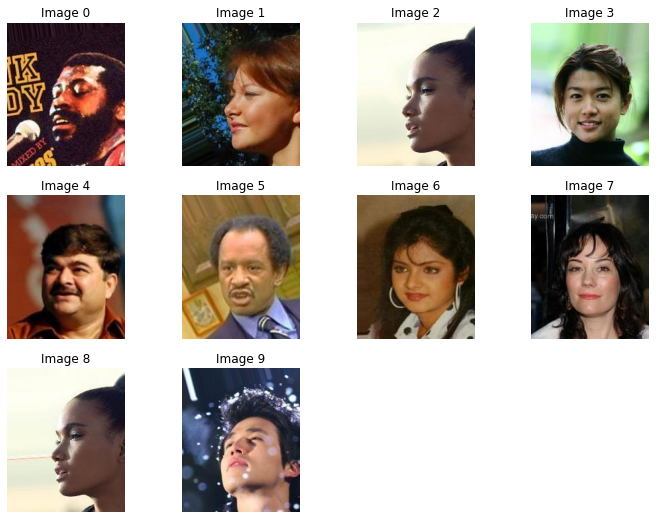

In [52]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(10)

In [53]:
learn.export(f"{os.getcwd()}/learners/multi_model.pkl")
# learn.save(f"{os.getcwd()}/learners/Arched_Eyebrows.pth")


In [77]:
learn.save

'C:\\Users\\magnu\\OneDrive\\Dokumente\\Datathon_2022'

# Unzipping

In [6]:
import zipfile
with zipfile.ZipFile("lumos-datathon.zip", 'r') as zip_ref:
    zip_ref.extractall("lumos_datathon")

In [5]:
os.getcwd()

'C:\\Users\\Magnus\\Documents\\GitHub\\FindWally'